# 📂 Project Pipeline 구조

데이터의 Path 및 실행 과정을 정리하여,  
새로운 파일이 들어왔을 때 어떤 위치에 두고 어떤 파일을 돌려야 하는지를 명확히 정의한다.

---

## 🐍 Python Scripts (./py 내부)

sapiens 실행에 필요한 주요 파이썬 파일은 총 5개:

1. **create_overlay.py**  
   - 생성된 JSON과 Frame을 이용하여 Overlay MP4 생성

2. **extract_frames.py**  
   - 입력한 MP4에서 Frame 추출

3. **extract_keypoints.py**  
   - Sapiens를 실행하여 Frame → Keypoints(JSON) 변환

4. **reextract_missing_keypoints.py**  
   - Keypoints 추출 과정에서 누락된 Frame만 재실행하여 보정

5. **process_video.py**  
   - **전체 파이프라인 실행 메인 함수**
   - 실행 단계: `frame → sapiens → reextract → overlay`
   - 각 단계 실행 여부는 선택 가능 (`run_frames`, `run_sapiens`, `run_reextract`, `run_overlay`)
   - 실행 상태를 `metadata.csv`의 컬럼 (`frames_done`, `sapiens_done`, `reextract_done`, `overlay_done`) 에 기록 및 갱신

---

## 📂 Data Directory 구조

데이터는 4단계로 나누어 관리한다.

```
data/
├── 0_RAW_DATA # 원본 MP4 저장
├── 1_FRAME # 추출된 Frame 저장
├── 2_KEYPOINTS # Sapiens로 추출된 Keypoints JSON 저장
├── 3_MP4 # 최종 Overlay MP4 저장
└── metadata.csv # 각 파일 처리 상태 기록
```


---

# 📑 METADATA.CSV 초기 설정

기존 Frame(.jpg), Keypoints(.json) 데이터를 복사해온 경우,  
처음 실행 시 `metadata.csv`를 올바르게 세팅해야 한다.

---

## 📂 CSV 구조

| Column Name       | 설명 |
|-------------------|----------------------------------------------------|
| `video_path`      | 원본 MP4 상대 경로 (기준: `data/0_RAW_DATA`) |
| `frame_path`      | 추출된 Frame 상대 경로 (기준: `data/1_FRAME`) |
| `keypoints_path`  | Keypoints JSON 상대 경로 (기준: `data/2_KEYPOINTS`) |
| `mp4_path`        | Overlay MP4 상대 경로 (기준: `data/3_MP4`) |
| `n_frames`        | 추출된 Frame 개수 |
| `n_json`          | 생성된 Keypoints JSON 개수 (보정 후 최종 값) |
| `frames_done`     | Frame 추출 완료 여부 (`True`/`False`) |
| `sapiens_done`    | Sapiens 실행 완료 여부 |
| `reextract_done`  | 누락 프레임 보정 완료 여부 |
| `overlay_done`    | Overlay MP4 생성 완료 여부 |

---

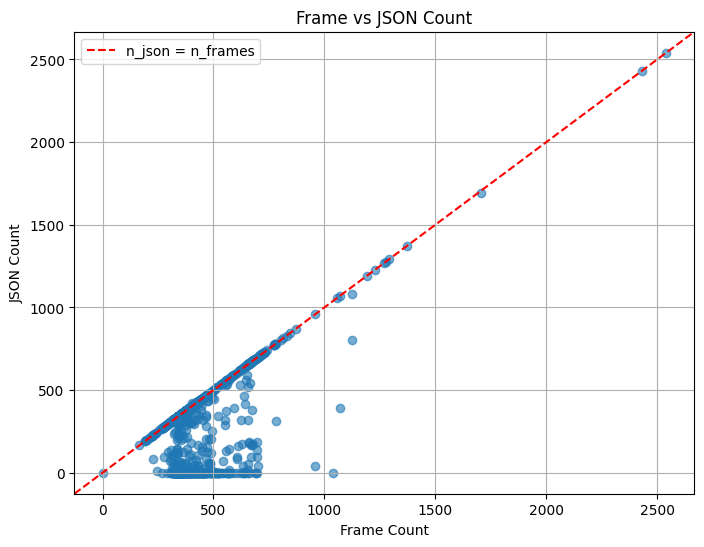

[SUMMARY] frames_done: {True: 1020, False: 1}
[SUMMARY] sapiens_done: {True: 707, False: 314}
[SUMMARY] reextract_done: {True: 600, False: 421}
[SUMMARY] overlay_done: {True: 517, False: 504}


In [5]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

"""
metadata 초기 생성 + 업데이트 (video_path 확장자 유지)

📌 기능:
- data/0_RAW_DATA 내부 MP4, MOV 파일 탐색
- 각 비디오별 frame/json 개수 확인
- metadata.csv 없거나 비어 있으면 새로 생성
- 기존 metadata.csv 있으면 merge 후 업데이트
- 시각화 및 요약 출력
"""

import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

# ---------------- 기본 경로 ----------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove")
DATA_DIR = BASE_DIR / "data"
CSV_PATH = DATA_DIR / "metadata.csv"

RAW_DIR  = DATA_DIR / "0_RAW_DATA"
FRAME_DIR = DATA_DIR / "1_FRAME"
KEYPOINT_DIR = DATA_DIR / "2_KEYPOINTS"
MP4_DIR = DATA_DIR / "3_MP4"

# ---------------- 유틸 함수 ----------------
def count_files(path: Path, suffix: str):
    if not path.exists():
        return 0
    return len(list(path.glob(f"*{suffix}")))

# ---------------- 새 metadata DataFrame 생성 ----------------
records = []
for video in RAW_DIR.rglob("*"):
    if video.suffix.lower() not in [".mp4", ".mov"]:
        continue
    
    rel_path_no_ext = video.relative_to(RAW_DIR).with_suffix("")
    rel_video_path  = video.relative_to(DATA_DIR)
    
    frame_path     = FRAME_DIR / rel_path_no_ext.parent / (rel_path_no_ext.name + "_frames")
    keypoints_path = KEYPOINT_DIR / rel_path_no_ext.parent / (rel_path_no_ext.name + "_JSON")
    mp4_path       = MP4_DIR / rel_path_no_ext.with_suffix(".mp4")

    n_frames = count_files(frame_path, ".jpg")
    n_json   = count_files(keypoints_path, ".json")

    ratio = (n_json / n_frames) if n_frames > 0 else 0.0

    row = {
        "video_path": str(rel_video_path),
        "frame_path": str(frame_path.relative_to(DATA_DIR)),
        "keypoints_path": str(keypoints_path.relative_to(DATA_DIR)),
        "mp4_path": str(mp4_path.relative_to(DATA_DIR)),
        "n_frames": n_frames,
        "n_json": n_json,
        "frames_done": n_frames > 0,
        "sapiens_done": (0.5 <= ratio <= 1.0),
        "reextract_done": (ratio == 1),
        "overlay_done": mp4_path.exists(),
    }
    records.append(row)

df_new = pd.DataFrame(records)

# ---------------- 기존 metadata 불러오기 ----------------
if CSV_PATH.exists() and CSV_PATH.stat().st_size > 0:
    try:
        df_old = pd.read_csv(CSV_PATH)
    except pd.errors.EmptyDataError:
        print("[WARN] metadata.csv 파일은 존재하지만 비어 있음 → 새로 생성")
        df_old = pd.DataFrame()
else:
    df_old = pd.DataFrame()

# ---------------- merge & 업데이트 ----------------
if not df_old.empty:
    merged = pd.merge(df_old, df_new, on="video_path", how="outer", suffixes=("_old", ""))
    for col in df_new.columns:
        if col != "video_path":
            merged[col] = merged[col].combine_first(merged[f"{col}_old"])
            if f"{col}_old" in merged.columns:
                merged.drop(columns=[f"{col}_old"], inplace=True)
    df_final = merged
else:
    print("[INFO] 기존 metadata.csv 없음/비어 있음 → 새로 생성")
    df_final = df_new

# ---------------- CSV 저장 ----------------
# df_final.to_csv(CSV_PATH, index=False, encoding="utf-8-sig")
# print(f"[INFO] metadata.csv 업데이트 완료 → {CSV_PATH}")

# ---------------- 시각화 ----------------
plt.figure(figsize=(8,6))
plt.scatter(df_final["n_frames"], df_final["n_json"], alpha=0.6)
plt.axline((0,0), slope=1, color="red", linestyle="--", label="n_json = n_frames")
plt.xlabel("Frame Count")
plt.ylabel("JSON Count")
plt.title("Frame vs JSON Count")
plt.legend()
plt.grid(True)
plt.show()

# ---------------- 분포 요약 ----------------
print("[SUMMARY] frames_done:", df_final["frames_done"].value_counts().to_dict())
print("[SUMMARY] sapiens_done:", df_final["sapiens_done"].value_counts().to_dict())
print("[SUMMARY] reextract_done:", df_final["reextract_done"].value_counts().to_dict())
print("[SUMMARY] overlay_done:", df_final["overlay_done"].value_counts().to_dict())


In [5]:
import pandas as pd
from pathlib import Path

# ---------------- 기본 경로 ----------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove")
DATA_DIR = BASE_DIR / "data"
CSV_PATH = DATA_DIR / "metadata.csv"

# ---------------- CSV 불러오기 ----------------
df = pd.read_csv(CSV_PATH)

# ---------------- test 폴더만 필터링 ----------------
mask = df["video_path"].str.contains("test/", case=False, na=False)
df_test = df[mask]

print(f"[INFO] test 폴더 비디오 개수: {len(df_test)}")

if len(df_test) > 0:
    # 상태 플래그 분포 요약
    for col in ["frames_done", "sapiens_done", "reextract_done", "overlay_done"]:
        if col in df_test.columns:
            print(f"\n[{col}] 분포:")
            print(df_test[col].value_counts(dropna=False))

    # 미리보기
    display(df_test[["video_path", "n_frames", "n_json",
                     "frames_done", "sapiens_done",
                     "reextract_done", "overlay_done"]].head(20))


[INFO] test 폴더 비디오 개수: 2

[frames_done] 분포:
frames_done
False    2
Name: count, dtype: int64

[sapiens_done] 분포:
sapiens_done
False    2
Name: count, dtype: int64

[reextract_done] 분포:
reextract_done
False    2
Name: count, dtype: int64

[overlay_done] 분포:
overlay_done
False    2
Name: count, dtype: int64


,video_path,n_frames,n_json,frames_done,sapiens_done,reextract_done,overlay_done
1019,0_RAW_DATA/test/Lumbar rotation3.MP4,0.0,0.0,False,False,False,False
1020,0_RAW_DATA/test/volleyball_14s.mp4,0.0,0.0,False,False,False,False


In [1]:
import sys
from pathlib import Path
import pandas as pd

# ---------------- 기본 경로 ----------------
BASE_DIR = Path("/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove")
DATA_DIR = BASE_DIR / "data"
CSV_PATH = DATA_DIR / "metadata.csv"

# ---------------- py 폴더 import ----------------
sys.path.append(str(BASE_DIR / "py"))
from process_video import process_video

# ---------------- metadata 불러오기 ----------------
df = pd.read_csv(CSV_PATH)

# ---------------- test 폴더 비디오만 선택 ----------------
mask = df["video_path"].str.contains("test/", case=False, na=False)
test_rows = df[mask]

print(f"[INFO] test 폴더 비디오 {len(test_rows)}개 발견")

# ---------------- 각 비디오 처리 ----------------
for _, row in test_rows.iterrows():
    video_path = DATA_DIR / row["video_path"]

    if not video_path.exists():
        print(f"[WARN] 파일 없음 → {video_path}")
        continue

    run_frames     = not bool(row.get("frames_done", False))
    run_sapiens    = not bool(row.get("sapiens_done", False))
    run_reextract  = not bool(row.get("reextract_done", False))
    run_overlay    = not bool(row.get("overlay_done", False))

    print(f"\n[PROCESS] {video_path}")
    print(f"  frames={run_frames}, sapiens={run_sapiens}, reextract={run_reextract}, overlay={run_overlay}")

    process_video(
        video_path,
        run_frames=run_frames,
        run_sapiens=run_sapiens,
        run_reextract=run_reextract,
        run_overlay=run_overlay
    )


/opt/conda/lib/python3.10/site-packages/mmengine/utils/package_utils.py:48: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


[INFO] test 폴더 비디오 2개 발견

[PROCESS] /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/0_RAW_DATA/test/Lumbar rotation3.MP4
  frames=True, sapiens=True, reextract=True, overlay=True
[INFO] Video    : /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/0_RAW_DATA/test/Lumbar rotation3.MP4
[INFO] Frames   : /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/1_FRAME/test/Lumbar rotation3_frames
[INFO] Keypoints: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/2_KEYPOINTS/test/Lumbar rotation3_JSON
[INFO] MP4      : /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/3_MP4/test/Lumbar rotation3.mp4


Extracting Frames: 100% 344/344 [00:14<00:00, 23.78it/s]
/opt/conda/lib/python3.10/importlib/__init__.py:169: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  _bootstrap._exec(spec, module)


[INFO] 프레임 추출 완료: 344 frames
Loads checkpoint by local backend from path: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/sapiens/pose/checkpoints/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth
Loads checkpoint by local backend from path: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, head.conv_layers.4.bias, head.conv_layers.4.running_mean, head.conv_layers.4.running_v

Sapiens:   0% 0/344 [00:00<?, ?frame/s]/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1695392020201/work/aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
Sapiens: 100% 344/344 [02:51<00:00,  2.01frame/s]


[INFO] Sapiens 추출 완료: 303 JSON
Loads checkpoint by local backend from path: /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/sapiens/pose/checkpoints/sapiens_0.3b/sapiens_0.3b_coco_best_coco_AP_796.pth
The model and loaded state dict do not match exactly

missing keys in source state_dict: head.deconv_layers.1.weight, head.deconv_layers.1.bias, head.deconv_layers.1.running_mean, head.deconv_layers.1.running_var, head.deconv_layers.4.weight, head.deconv_layers.4.bias, head.deconv_layers.4.running_mean, head.deconv_layers.4.running_var, head.conv_layers.1.weight, head.conv_layers.1.bias, head.conv_layers.1.running_mean, head.conv_layers.1.running_var, head.conv_layers.4.weight, head.conv_layers.4.bias, head.conv_layers.4.running_mean, head.conv_layers.4.running_var



Lumbar rotation3.MP4 (re-infer): 100% 41/41 [00:21<00:00,  1.87frame/s]


[INFO] Lumbar rotation3.MP4: 최종 JSON 개수 344
[INFO] 누락 보정 후 최종 JSON: 344


Creating Overlay: 100% 344/344 [00:05<00:00, 59.00frame/s]


[INFO] Overlay mp4 생성 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/3_MP4/test/Lumbar rotation3.mp4
[INFO] metadata.csv 갱신 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/metadata.csv
[WARN] 파일 없음 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/0_RAW_DATA/test/volleyball_14s.mp4


## METADATA UPDATE

In [1]:
import os
import pandas as pd

BASE_DIR = "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove"
csv_path = os.path.join(BASE_DIR, "data", "metadata.csv")

df = pd.read_csv(csv_path)

for idx, row in df.iterrows():
    frame_path = row.get("frame_path", "")
    keypoints_path = row.get("keypoints_path", "")

    # --- n_frames / frames_done 업데이트 ---
    if "Won_Kim_research_at_Bosanjin" in frame_path:
        abs_frame_path = os.path.join(BASE_DIR, "data", frame_path)
        if os.path.exists(abs_frame_path):
            n_frames = len([f for f in os.listdir(abs_frame_path) if f.endswith((".jpg", ".png"))])
        else:
            n_frames = 0
        df.at[idx, "n_frames"] = n_frames
        df.at[idx, "frames_done"] = n_frames > 0

    # --- n_json 업데이트 ---
    if "Won_Kim_research_at_Bosanjin" in keypoints_path:
        abs_json_path = os.path.join(BASE_DIR, "data", keypoints_path)
        if os.path.exists(abs_json_path):
            n_json = len([f for f in os.listdir(abs_json_path) if f.endswith(".json")])
        else:
            n_json = 0
        df.at[idx, "n_json"] = n_json

# 저장
out_path = os.path.join(BASE_DIR, "data", "metadata_updated.csv")
df.to_csv(out_path, index=False)

print(f"✅ metadata.csv 업데이트 완료 → {out_path}")


✅ metadata.csv 업데이트 완료 → /workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove/data/metadata_updated.csv


In [2]:
import os
import pandas as pd

BASE_DIR = "/workspace/nas203/ds_RehabilitationMedicineData/IDs/Kimjihoo/3_project_HCCmove"
csv_path = os.path.join(BASE_DIR, "data", "metadata_updated.csv")

df = pd.read_csv(csv_path)

# 불일치 데이터프레임 추출
mismatch_df = df[df["n_frames"] != df["n_json"]]

# 불일치 개수 출력
print(f"⚠️ n_frames ≠ n_json 인 행 개수: {len(mismatch_df)}")

# 전체 행 출력
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(mismatch_df[["frame_path", "keypoints_path", "n_frames", "n_json"]])

# CSV로 저장
out_path = os.path.join(BASE_DIR, "data", "metadata_mismatch.csv")
mismatch_df.to_csv(out_path, index=False)
print(f"\n✅ 불일치 전체 저장 완료 → {out_path}")


⚠️ n_frames ≠ n_json 인 행 개수: 91
                                             frame_path  \
27    1_FRAME/AI_dataset/N01/N01_Treatment/SLR_bobat...   
35    1_FRAME/AI_dataset/N01/N01_Ward/Biceps Curl_3_...   
46    1_FRAME/AI_dataset/N01/N01_Ward/Chest Press2_f...   
55    1_FRAME/AI_dataset/N01/N01_Ward/Hip Extension2...   
79    1_FRAME/AI_dataset/N01/N01_Ward/Overhead Trice...   
91    1_FRAME/AI_dataset/N01/N01_Ward/Shoulder Abduc...   
94    1_FRAME/AI_dataset/N01/N01_Ward/Shoulder Flexi...   
154   1_FRAME/AI_dataset/N02/N02_Ward/Hip abduction2...   
222   1_FRAME/AI_dataset/N03/N03_Ward/Ankle Pumping1...   
223   1_FRAME/AI_dataset/N03/N03_Ward/Ankle Pumping2...   
224   1_FRAME/AI_dataset/N03/N03_Ward/Ankle Pumping3...   
226   1_FRAME/AI_dataset/N03/N03_Ward/Biceps Curl2_f...   
227   1_FRAME/AI_dataset/N03/N03_Ward/Biceps Curl3_f...   
229   1_FRAME/AI_dataset/N03/N03_Ward/Biceps Curl_Bi...   
230   1_FRAME/AI_dataset/N03/N03_Ward/Biceps Curl_Bi...   
232   1_FRAME/AI_dataset